# Conv1D implementation of Toxic Comments

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import text,sequence
from tensorflow.keras.layers import Conv1D,MaxPool1D,GlobalMaxPool1D,Dense,Input,Embedding
from tensorflow.keras.models import Model
from sklearn.metrics import roc_auc_score
%matplotlib inline

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Limited tf.compat.v2.summary API due to missing TensorBoard installation
Limited tf.summary API due to missing TensorBoard installation


## Model configuration

In [51]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 1

## Loading pre-trained embeddings
For this model pre-trained embeddings are retrieved from Glove.

In [3]:
glove_dir=os.curdir+'/Glove Embeddings/'

### Creates a dictionary with all words and corresponding embedding

In [4]:
print('Loading word vectors...')
word2vec = {}
with open(os.path.join(glove_dir+'glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


### Get comments from .csv file

In [5]:
print('Loading in comments...')

train = pd.read_csv(os.curdir+"/train.csv")
# train.describe()
# train.info()
sentences = train["comment_text"]
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

Loading in comments...


## Step 1: Tokenization

In [6]:
tokenizer = text.Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

max sequence length: 1400
min sequence length: 0
median sequence length: 35


### Create a dictionary with word index mapping

In [7]:
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


### Pad tokens so all have the same length

In [8]:
data=sequence.pad_sequences(sequences,maxlen=MAX_SEQUENCE_LENGTH)

## Step 2: Association
Set-up embedding matrix with pre-trained Glove word vectors

In [9]:
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector


Filling pre-trained embeddings...


## Build Model

### Set-up pre-trained embedding layer

In [74]:
embedding_layer=Embedding(num_words,EMBEDDING_DIM,trainable=True,weights=[embedding_matrix],embeddings_initializer=None)

In [75]:
embedding_layer.get_config()

{'name': 'embedding_6',
 'trainable': True,
 'batch_input_shape': (None, None),
 'dtype': 'float32',
 'input_dim': 20000,
 'output_dim': 100,
 'embeddings_initializer': None,
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': False,
 'input_length': None}

In [76]:
print('Build Model...')
input_=Input(shape=(MAX_SEQUENCE_LENGTH,))
x=embedding_layer(input_)
x=Conv1D(128,3,activation='relu')(x)
x=MaxPool1D(3)(x)
x=Conv1D(128,3,activation='relu')(x)
x=MaxPool1D(3)(x)
x=Conv1D(128,3,activation='relu')(x)
x=GlobalMaxPool1D()(x)
x=Dense(128,activation='relu')(x)
output=Dense(len(possible_labels),activation='sigmoid')(x)
model=Model(input_,output)
model.summary()
model.layers[1].get_weights()[0][0]

Build Model...
Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 98, 128)           38528     
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 32, 128)           0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 30, 128)           49280     
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 10, 128)           0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 8, 128)

array([-0.01145134,  0.01235417, -0.00713845, -0.00110613, -0.00587892,
       -0.00942557, -0.00383783,  0.00701621, -0.01136712, -0.01111013,
        0.00367836,  0.0060691 ,  0.00124634,  0.01162926,  0.01354614,
       -0.00705278,  0.01296348, -0.01082747,  0.01720184, -0.01669049,
       -0.00774464, -0.00704234, -0.00352526,  0.00681817, -0.00540088,
       -0.00705027,  0.00788116, -0.00352252, -0.01613357, -0.00704914,
       -0.01474151,  0.00661024,  0.00238227, -0.01246695, -0.01319456,
       -0.00368215, -0.00925394, -0.01436717,  0.00313533,  0.00233355,
        0.00873325,  0.00744162, -0.00776358, -0.00525398, -0.01326942,
       -0.00882214,  0.0138756 , -0.00941019, -0.01394831, -0.01473474,
        0.01324001,  0.01517478,  0.0119536 ,  0.01700238, -0.00158481,
       -0.00771952, -0.01348577, -0.00041973,  0.00759395,  0.01617836,
       -0.00645523, -0.00202959, -0.01416039, -0.00305121,  0.00698208,
       -0.00842063,  0.00060712,  0.00819907,  0.01629282,  0.01

In [66]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [67]:
history=model.fit(data,targets,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=VALIDATION_SPLIT)

Train on 127656 samples, validate on 31915 samples
127656/127656 [==============================] - 101s 795us/sample - loss: 0.0854 - acc: 0.9740 - val_loss: 0.0642 - val_acc: 0.9782


In [69]:
modelEmb = Model(inputs = model.inputs, outputs = model.layers[1].output)
testing = data[0]
testing = np.expand_dims(testing, axis = 0)
print(testing[0][0])
print(model.layers[1].get_weights()[0][0])
embedding_matrix[testing[0][0]]

0
[ 0.01060211 -0.01161762 -0.00511805  0.02396164 -0.01007519  0.01847268
  0.00961737  0.00797975  0.00647864  0.00215046 -0.00833128  0.00545689
  0.00951052  0.02163084  0.01537829  0.02309409 -0.02444701 -0.00996886
 -0.02531204  0.00111352 -0.00252873 -0.00458206  0.01340589  0.0157339
 -0.01775133  0.00453458  0.00951737  0.0105435   0.01750541  0.01152024
  0.00770876 -0.00472083 -0.0006267   0.00450969  0.01545251  0.00127232
 -0.01331915  0.00594866  0.00622714 -0.01312502 -0.00260323  0.00077782
  0.00221514 -0.01251605  0.0085448  -0.00588066  0.02276019 -0.01451966
  0.00146549 -0.00130481 -0.01588192  0.01436985  0.01984121 -0.01319628
  0.0021439  -0.01772026 -0.0100085   0.00090577 -0.01691351  0.00641011
 -0.01921154  0.00863384  0.0090596   0.00115517  0.00039947 -0.00169625
  0.01072351 -0.00382791 -0.01632489  0.02061623  0.01963478 -0.00812556
  0.02513642 -0.00158214  0.00472768  0.01721553 -0.02721805  0.00431554
  0.01379     0.02511104 -0.00446744 -0.00125549  

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Loss and accuracy plots

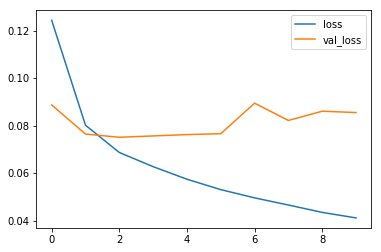

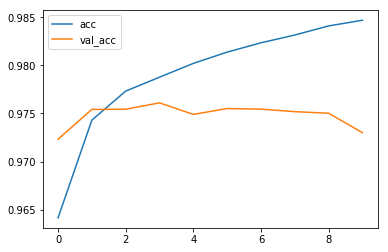

In [55]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()

## AUC ROC metric calculation

In [56]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.976971588800461
